# HOPFIELD 

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

### Basics Functions

In [150]:
# train matrix with pattern list
def train(patterns, height, width):
    patterns = np.array(patterns)
    nums_neurons = height * width
    global W
    W = np.zeros((nums_neurons, nums_neurons))

    for p in patterns:
        W += np.outer(p, p)

    np.fill_diagonal(W, 0)
    W /= len(patterns)

# zwykł np.sign dla zera zwraca 0
def sign(x):
    # return np.sign(x)
    return np.where(x >= 0, 1, -1)

def update_sync(state):
    return sign(W @ state)

def energy(state):
    return -0.5 * state.T @ W @ state

In [189]:
def run_single(state):
    return sign(W @ state)

def run(state, max_iter=20):
    history = [state.copy()]
    for iter in range(0,max_iter):
        new_state = sign(W @ state)
        history.append(new_state.copy())
        if np.array_equal(new_state, state):
            break
        state = new_state

    return state, history

def run_async(state, max_iters=10):
    history = [state.copy()]
    s = state.copy()
    n = len(s)
    for _ in range(max_iters):
        idxs = np.random.permutation(n)
        for i in idxs:
            h_i = W[i] @ s
            s[i] = 1 if h_i >= 0 else -1

    history.append(s.copy())
    
    return s, history

In [195]:
# basic plot
def basic_plot(pattern, height, width):
    img = pattern.reshape(height, width)
    plt.imshow(img, cmap="gray")
    plt.show()


def plot_triplet(
    original,
    noisy,
    recovered,
    height,
    width,
    first_title="Original",
    second_title="Noisy",
    third_title="Recovered",
):
    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].imshow(original.reshape(height, width), cmap="gray")
    axes[0].set_title(first_title)
    axes[0].axis("off")

    axes[1].imshow(noisy.reshape(height, width), cmap="gray")
    axes[1].set_title(second_title)
    axes[1].axis("off")

    axes[2].imshow(recovered.reshape(height, width), cmap="gray")
    axes[2].set_title(third_title)
    axes[2].axis("off")

    plt.tight_layout()
    plt.show()


def plot_iterations(images, height, width, cols=5):
    n = len(images)
    rows = int(np.ceil(n / cols))

    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 3*rows))

    if rows == 1:
        axes = np.array([axes])

    for i, img in enumerate(images):
        r = i // cols
        c = i % cols
        ax = axes[r, c]

        img_to_show = img.reshape(height, width)

        ax.imshow(img_to_show, cmap="gray")
        ax.set_title(f"Iter {i}")
        ax.axis("off")

    for i in range(n, rows * cols):
        r = i // cols
        c = i % cols
        axes[r, c].axis("off")

    plt.tight_layout()
    plt.show()

In [130]:
def basic_noise(pattern, nums_neurons, noise_level):
    noisy = pattern.copy()
    idx = np.random.choice(nums_neurons, int(nums_neurons * noise_level), replace=False)
    noisy[idx] *= -1
    return noisy

In [131]:
# load data and set sizes
data_set_list = [
    "animals-14x9.csv",
    "large-25x25.csv",
    "large-25x25.plus.csv",
    "large-25x50.csv",
    "letters-14x20.csv",
    "letters-abc-8x12.csv",
    "OCRA-12x30-cut.csv",
    "small-7x7.csv",
]

vecs = np.loadtxt(f"data/{data_set_list[0]}", delimiter=",")

# tricky w niektrórych zbiorach dlatego ustawiane ręcznie
height = 9
width = 14
nums_neurons = height * width

In [132]:
train(vecs, height=height, width=width)

In [173]:
# choose image
indx = 2

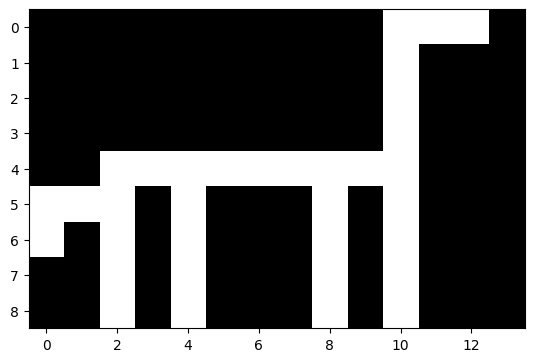

In [183]:
basic_plot(vecs[indx], height, width)

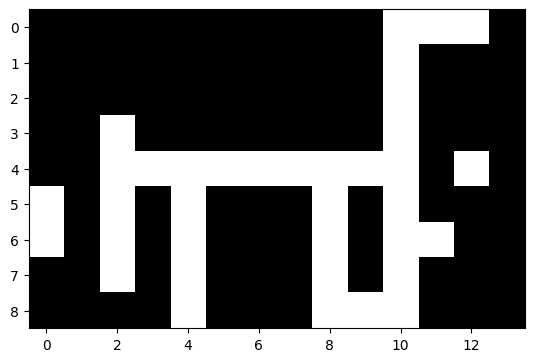

In [190]:
# basic noise
noise_level = 0.05
noisy = basic_noise(vecs[indx], nums_neurons, noise_level)
basic_plot(noisy, height, width)

energy original: -1783.9999999999993
energy single: -1907.9999999999998
energy recovered: -2078.666666666667
energy recovered async : -2078.666666666667


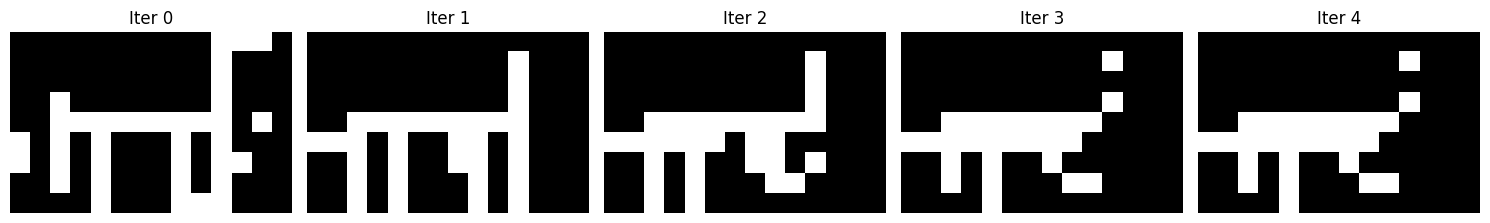

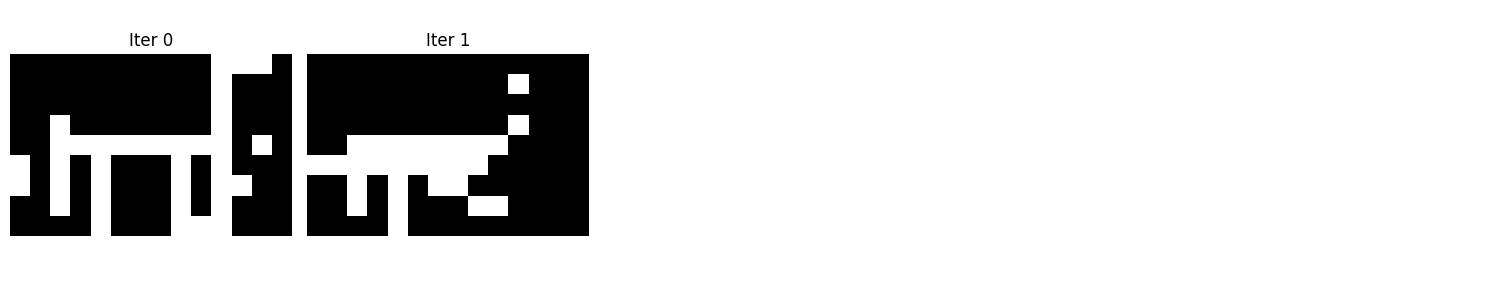

In [198]:
recovered, history_run = run(noisy)
recovered_single = run_single(noisy)
recovered_async, history_async_run = run_async(noisy)

print("energy original:", energy(vecs[indx]))
print("energy single:", energy(recovered_single))
print("energy recovered:", energy(recovered))
print("energy recovered async :", energy(recovered_async))


plot_iterations(history_run, height, width)
plot_iterations(history_async_run, height, width)

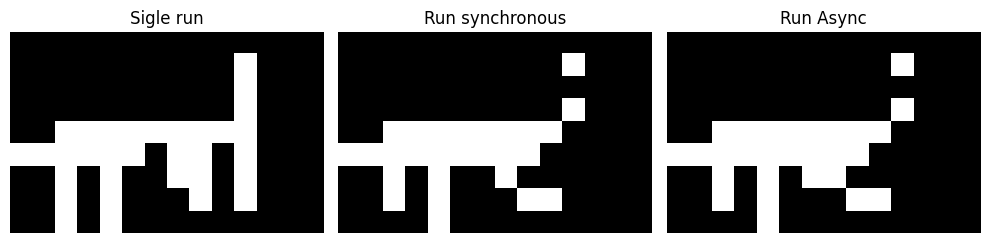

In [182]:
plot_triplet(recovered_single, recovered, recovered_async, height, width, "Sigle run", "Run synchronous", "Run Async")

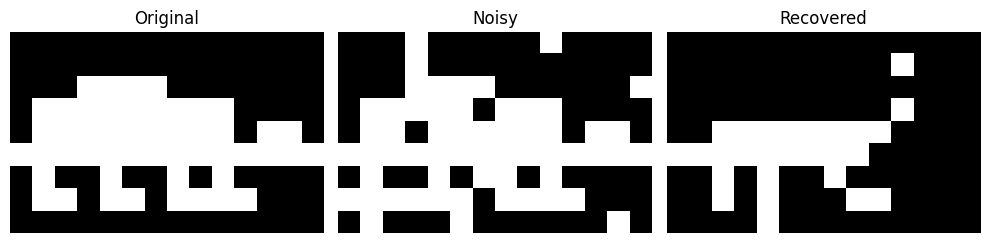

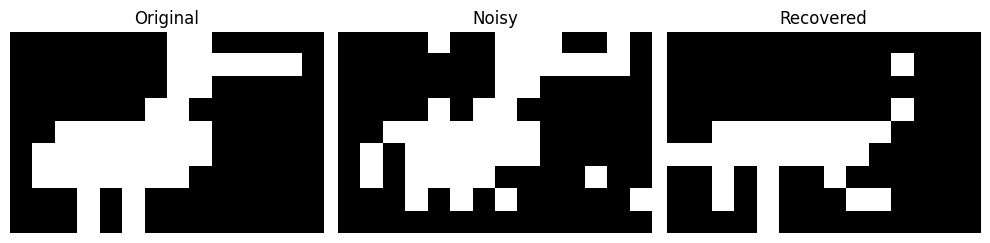

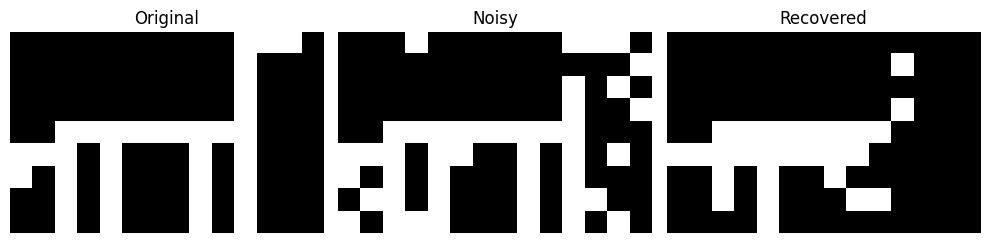

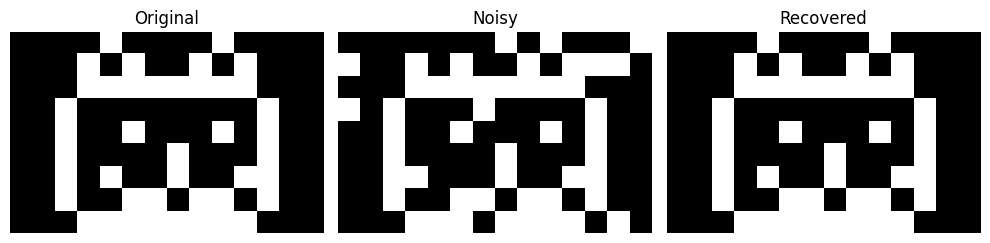

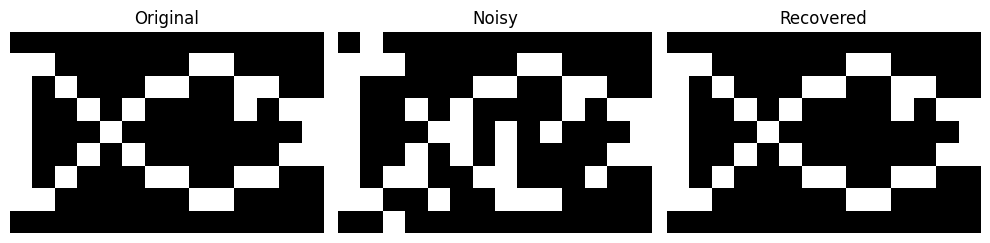

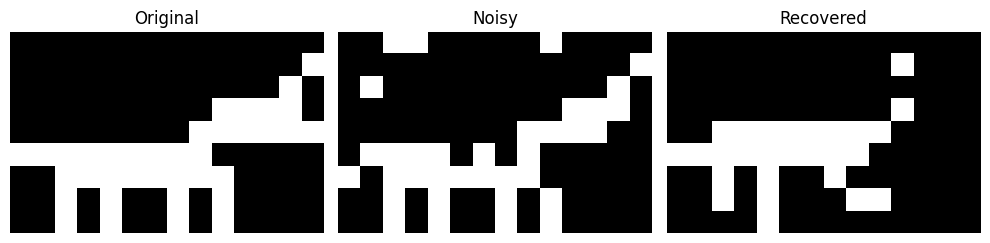

In [187]:

for vec in vecs:
    noisy = basic_noise(vec, nums_neurons, 0.1)
    recovered = run(noisy)
    plot_triplet(vec, noisy, recovered, height, width)